In [2]:
import urllib.request
urllib.request.urlretrieve("http://misc.0093.tv/misc/kadai.xlsx", "kadai.xlsx")

('kadai.xlsx', <http.client.HTTPMessage at 0x1ea31f17ed0>)

In [3]:
# ライブラリのインポート
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

c:\Users\yuema\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
df = pd.read_excel("kadai.xlsx")
# 変数の指定
target = 'OV'
features = df.drop(columns=[target]).columns.tolist()

In [20]:
# 前処理と外れ値の処理
# 0. "process_end_time"と"final_mes_time"を時系列オブジェクトに変換する
df["process_end_time"] = pd.to_datetime(df["process_end_time"])
df["final_mes_time"] = pd.to_datetime(df["final_mes_time"])

# 1. 欠損値の確認
#df.info()

# 2. 外れ値の確認(IQR法)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliners = df[(df[target] < lower_bound) | (df[target] > upper_bound)]

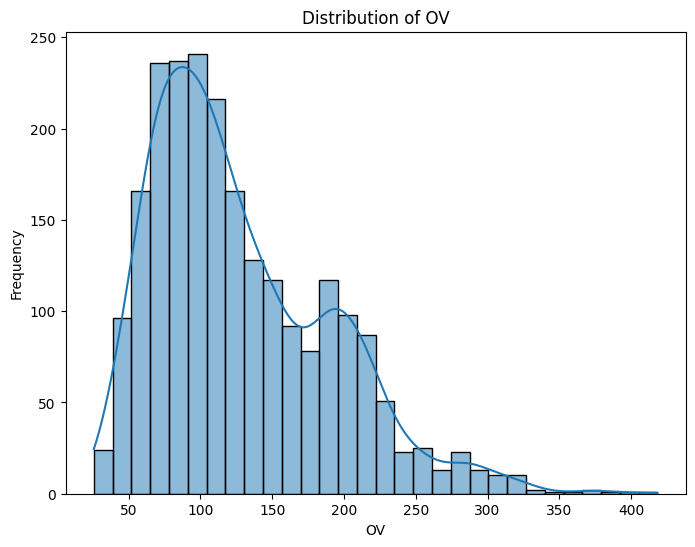

In [8]:
# ヒストグラム
plt.figure(figsize=(8, 6))
sns.histplot(df[target], bins=30, kde=True)
plt.title('Distribution of OV')
plt.xlabel('OV')
plt.ylabel('Frequency')
plt.show()

In [9]:
# SVMのモデル構築
svm_params = {
    'C': 10,
    'epsilon': 0.1,
    'kernel': 'rbf',
    'gamma': 0.1
}

svm_model = SVR(**svm_params)

# LightGBMのモデル構築
gbm_params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.5,
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'min_child_samples': 20,
    'n_estimators': 1000,
    'verbose': -1
    }

lgb_model = lgb.LGBMRegressor(**gbm_params, random_state=42)    

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 86.19047886405512


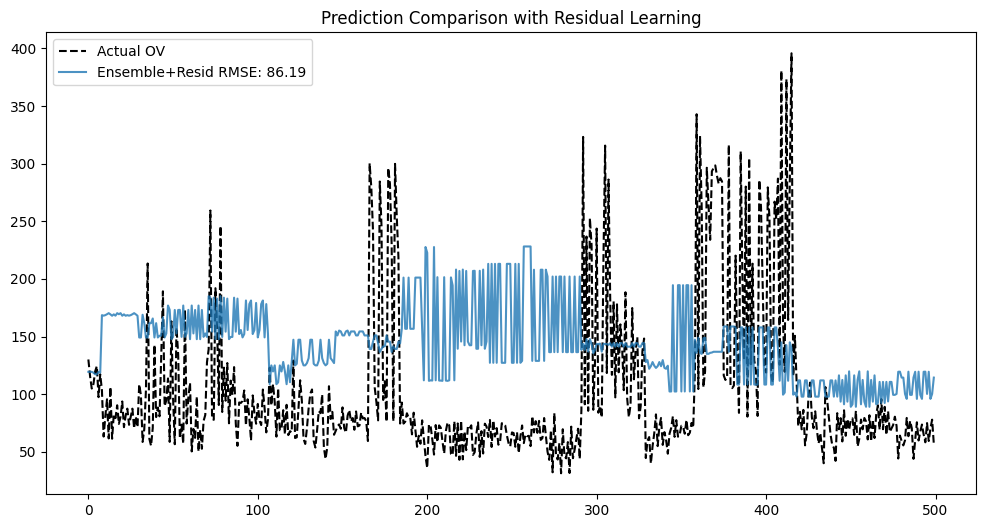

In [10]:
# 全変数Tweedieモデル
df1 = df.copy()
y_Hat = []
y_svm = []
y_lr = []

end = min(2276, len(df1))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df1[0:i].copy().dropna()
    test = df1[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    

    y_Hat.append(pred[0])

Y_t = df["OV"][1776:2276].reset_index(drop=True)
Y_t = Y_t.reset_index()['OV']

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 64.30470691617303


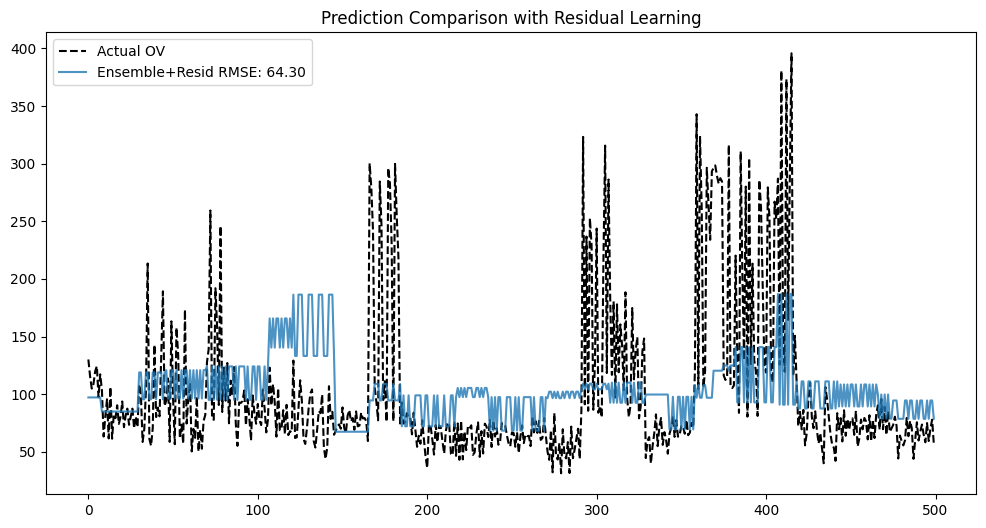

In [11]:
# Tweedieモデル(変数選択Var)
df2 = df.copy()
df2 = df2[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

end = min(2276, len(df1))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df2[0:i].copy().dropna()
    test = df2[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]

    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    

    y_Hat.append(pred[0])

Y_t = df["OV"][1776:2276].reset_index(drop=True)
Y_t = Y_t.reset_index()['OV']

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 58.96349904414934


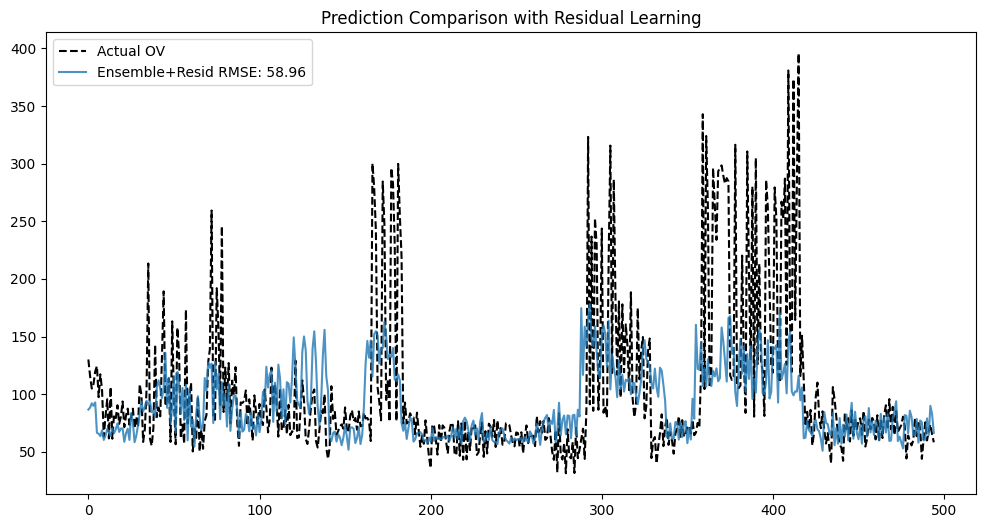

In [ ]:
# Tweedieモデル(変数選択Var)
df3 = df.copy()
df3 = df3[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df3[f"{target}_lag{lag}"] = df3[target].shift(lag)

# 2. 差分特徴量
df3[f"{target}_diff"] = df3[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df3[f"{target}_roll_mean{window}"] = df3[target].rolling(window).mean().shift(1)
  df3[f"{target}_roll_std{window}"] = df3[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df3 = df3.dropna().reset_index(drop=True)

end = min(2276, len(df3))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df3[0:i].copy().dropna()
    test = df3[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Start Prediction with Clustering (k=5, window=24)...
Processing index: 1776 / 2252
Processing index: 1826 / 2252
Processing index: 1876 / 2252
Processing index: 1926 / 2252
Processing index: 1976 / 2252
Processing index: 2026 / 2252
Processing index: 2076 / 2252
Processing index: 2126 / 2252
Processing index: 2176 / 2252
Processing index: 2226 / 2252
Clustering Augmented Ensemble RMSE: 88.0229


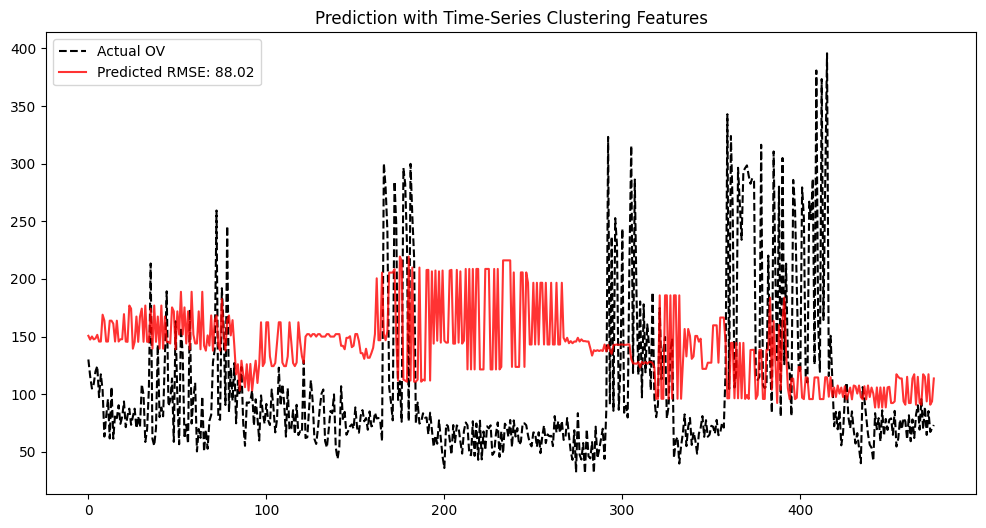

In [18]:
from sklearn.cluster import KMeans  # 追加: クラスタリング用

df4 = df.copy()
# ---------------------------------------------------------
# 事前準備: 波形認識用のラグ変数を作成
# ---------------------------------------------------------
# 論文を参考に、過去24時点(window_size)のデータを「波形」として扱います
window_size = 24
lag_cols = []

# まだラグ変数が作られていない場合のために作成
for i in range(1, window_size + 1):
    col_name = f'lag_{i}'
    df4[col_name] = df4[target].shift(i)
    lag_cols.append(col_name)

# ラグ作成による欠損を削除
df4 = df4.dropna().reset_index(drop=True)

# ---------------------------------------------------------
# ループ処理開始
# ---------------------------------------------------------
y_Hat = []
end_index = min(2276, len(df4))  # df4を使用（ラグ処理済み）

print(f"Start Prediction with Clustering (k=5, window={window_size})...")

for i in np.arange(1776, end_index):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / {end_index}")

    # 1. データ分割 (ウォークフォワード)
    learn = df4[0:i].copy()
    test = df4[i:i+1].copy()
    
    # 時間順序を守る
    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    if len(test) > 0:
        learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    else:
        continue

    # 学習データが空でないかチェック
    if len(learn) == 0:
        continue

    # -----------------------------------------------------
    # Step A: 時系列クラスタリング (波形の分類)
    # -----------------------------------------------------
    # 過去24点のラグ変数だけを取り出す（これが「波形の形」を表す）
    X_cluster_learn = learn[lag_cols]
    X_cluster_test = test[lag_cols]

    # クラスタリング用に標準化 (波形の「形」を見たいのでスケールを揃える)
    scaler_cl = StandardScaler()
    X_cl_l_scaled = scaler_cl.fit_transform(X_cluster_learn)
    X_cl_t_scaled = scaler_cl.transform(X_cluster_test)

    # K-Means実行 (クラスタ数=5程度が妥当)
    # 論文では階層型だが、計算速度重視でK-Meansを採用
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # 学習データの波形パターンを学習 & 分類
    learn_labels = kmeans.fit_predict(X_cl_l_scaled)
    # テストデータの波形パターンを予測 (※testでfitしてはいけない)
    test_labels = kmeans.predict(X_cl_t_scaled)

    # -----------------------------------------------------
    # Step B: クラスタIDを特徴量に追加 (One-Hot Encoding)
    # -----------------------------------------------------
    # SVMやLassoは「カテゴリ値(0,1,2...)」を数値の大小として誤解するため、
    # 必ず One-Hot (ダミー変数) に変換する
    
    # 学習データへの追加
    cluster_dummies_l = pd.get_dummies(learn_labels, prefix='Cluster').astype(int)
    # すべてのクラスタ列(0~4)が揃うように調整 (稀なクラスタが出ない場合対策)
    for c in range(n_clusters):
        if f'Cluster_{c}' not in cluster_dummies_l.columns:
            cluster_dummies_l[f'Cluster_{c}'] = 0
    # 列順序を固定
    cluster_dummies_l = cluster_dummies_l[sorted(cluster_dummies_l.columns)]
    
    # テストデータへの追加
    cluster_dummies_t = pd.get_dummies(test_labels, prefix='Cluster').astype(int)
    for c in range(n_clusters):
        if f'Cluster_{c}' not in cluster_dummies_t.columns:
            cluster_dummies_t[f'Cluster_{c}'] = 0
    cluster_dummies_t = cluster_dummies_t[sorted(cluster_dummies_t.columns)]

    # -----------------------------------------------------
    # Step C: メインの学習データの作成
    # -----------------------------------------------------
    # ベースの特徴量 (変数選択済みのものなど)
    base_cols = [c for c in df4.columns if c not in ['process_end_time', 'final_mes_time', target] + lag_cols]
    
    # ベース特徴量 + クラスタ特徴量 を結合
    X_l = pd.concat([learn[base_cols].reset_index(drop=True), cluster_dummies_l.reset_index(drop=True)], axis=1)
    y_l = learn[target]
    
    X_t = pd.concat([test[base_cols].reset_index(drop=True), cluster_dummies_t.reset_index(drop=True)], axis=1)

    # -----------------------------------------------------
    # Step D: モデル学習 (アンサンブル)
    # -----------------------------------------------------
    # Xのスケーリング (Lasso/SVM用)
    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    # 1.
    lgb_model.fit(X_l_scaled, y_l)
    pred_lgb = lgb_model.predict(X_t_scaled)[0]

    # 合体
    final_pred = pred_lgb
    y_Hat.append(final_pred)

# --- 評価 ---
# 予測値と同じ個数だけ実際の値を取得
Y_t = df[target].iloc[1776:(1776 + len(y_Hat))].reset_index(drop=True).values
yh = np.array(y_Hat)

rmse = np.sqrt(mean_squared_error(Y_t, yh))
print(f"Clustering Augmented Ensemble RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
plt.plot(yh, label=f'Predicted RMSE: {rmse:.2f}', color='red', alpha=0.8)
plt.title("Prediction with Time-Series Clustering Features")
plt.legend()
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 58.96349904414934


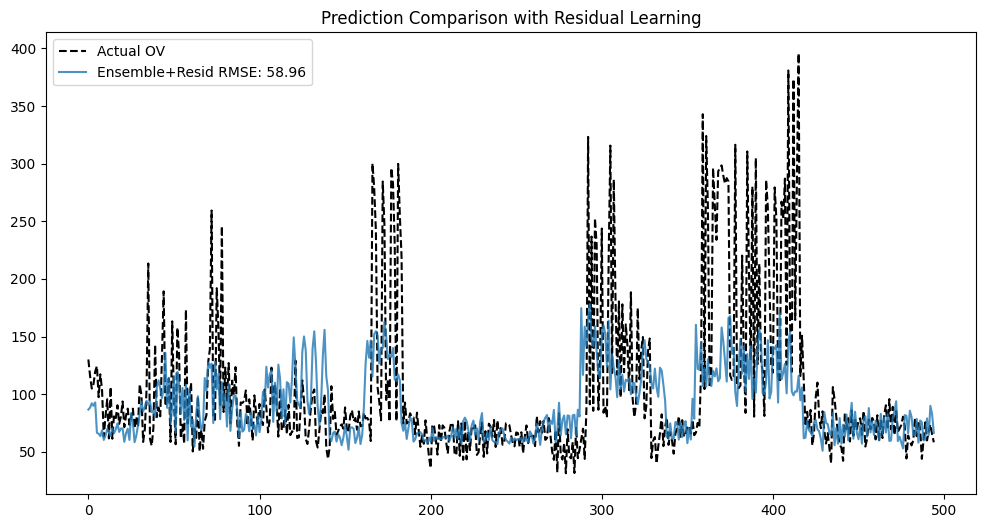

In [22]:
# Tweedieモデル(Seed Averaging)
df5 = df.copy()
df5 = df5[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]

y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df5[f"{target}_lag{lag}"] = df5[target].shift(lag)

# 2. 差分特徴量
df5[f"{target}_diff"] = df5[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df5[f"{target}_roll_mean{window}"] = df5[target].rolling(window).mean().shift(1)
  df5[f"{target}_roll_std{window}"] = df5[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df5 = df5.dropna().reset_index(drop=True)

end = min(2276, len(df5))

for i in np.arange(1776, end):
    pred_list = []
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df5[0:i].copy().dropna()
    test = df5[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    for j in range(5):
        model = lgb.LGBMRegressor(**gbm_params, random_state=42 + j)
        model.fit(X_l_scaled, y_l)
        pred_list.append(model.predict(X_t_scaled)[0])

    pred = np.mean(pred_list)
    
    y_Hat.append(pred)

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

# 全変数RMSE:69.36397560482494

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
LightGBM(Tweedie)): 82.02603471465709


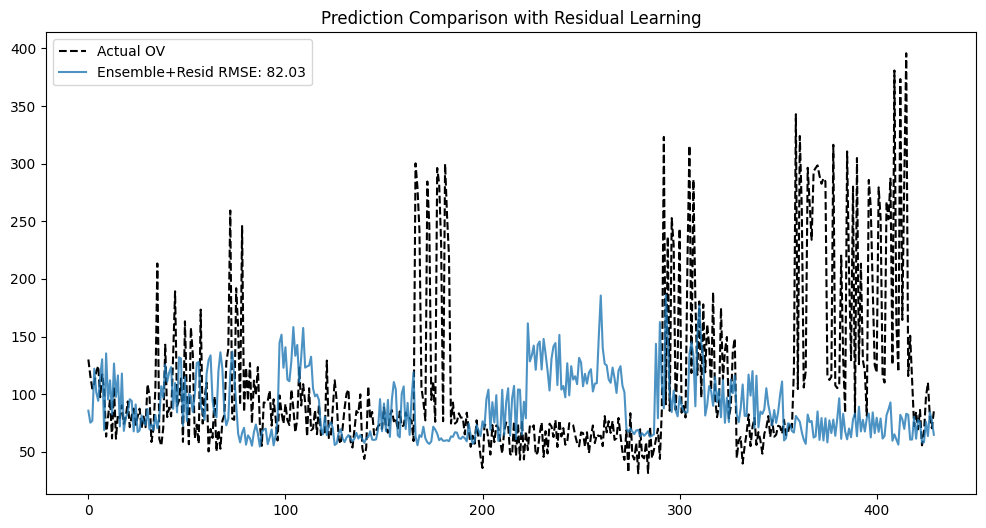

In [24]:
# Tweedieモデル(変数選択Var)
df6 = df.copy()
df6 = df6[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]
y_Hat = []
y_svm = []
y_lr = []

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df6[f"{target}_lag{lag}"] = df6[target].shift(lag)

# 2. 差分特徴量
df6[f"{target}_diff"] = df6[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df6[f"{target}_roll_mean{window}"] = df6[target].rolling(window).mean().shift(1)
  df6[f"{target}_roll_std{window}"] = df6[target].rolling(window).std().shift(1)

# 過去70単位期間の最大値と最小値
df6[f"{target}_roll_max70"] = df6[target].rolling(70).max().shift(1)
df6[f"{target}_roll_min70"] = df6[target].rolling(70).min().shift(1)

# 4. Shiftへの対応
df6 = df6.dropna().reset_index(drop=True)
end = min(2276, len(df6))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df6[0:i].copy().dropna()
    test = df6[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    lgb_model.fit(X_l_scaled, y_l)

    pred = lgb_model.predict(X_t_scaled)
    
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values

plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')

yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")

plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()

Processing index: 1776 / 2276
Processing index: 1826 / 2276
Processing index: 1876 / 2276
Processing index: 1926 / 2276
Processing index: 1976 / 2276
Processing index: 2026 / 2276
Processing index: 2076 / 2276
Processing index: 2126 / 2276
Processing index: 2176 / 2276
Processing index: 2226 / 2276
LightGBM(Tweedie)): 57.23072554923855


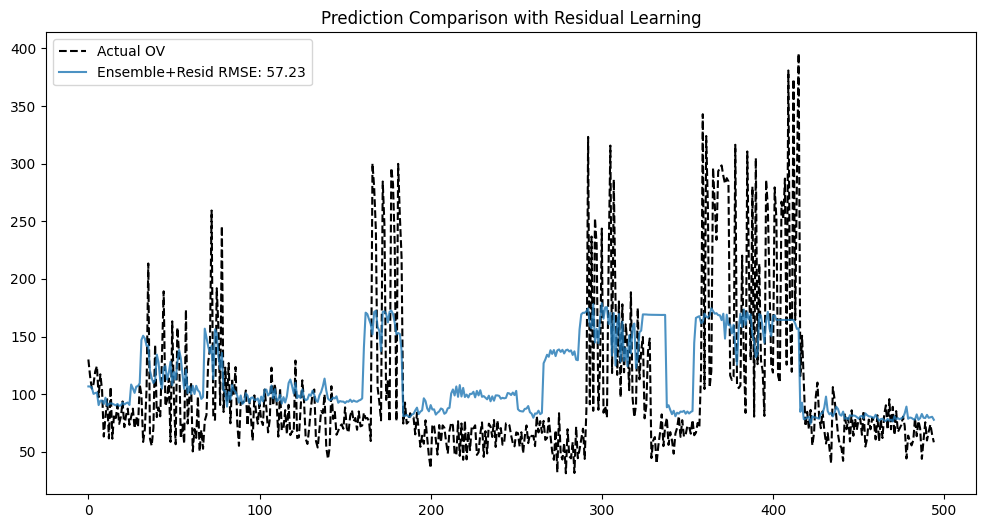

In [26]:
df7 = df.copy()
y_Hat = []
pred_12 = []
pred_22 = []
pred_32 = []
pred_42 = []
pred_52 = []

df7 = df7[["X14", "X30", "X33", "X83", "OV", "process_end_time", "final_mes_time"]]

# 特徴量エンジニアリング
# 1. Lag特徴量
lags = [1, 2, 3, 5]
for lag in lags:
  df7[f"{target}_lag{lag}"] = df7[target].shift(lag)

# 2. 差分特徴量
df7[f"{target}_diff"] = df7[target].diff(1).shift(1)

# 3. 移動平均と移動標準偏差
windows = [3, 5]
for window in windows:
  df7[f"{target}_roll_mean{window}"] = df7[target].rolling(window).mean().shift(1)
  df7[f"{target}_roll_std{window}"] = df7[target].rolling(window).std().shift(1)

# 4. Shiftへの対応
df7 = df7.dropna().reset_index(drop=True)

end = min(2276, len(df7))

for i in np.arange(1776, end):
    if (i - 1776) % 50 == 0:
        print(f"Processing index: {i} / 2276")

    learn = df7[0:i].copy().dropna()
    test = df7[i:i+1].copy()

    learn = learn.reset_index(drop=True)
    test = test.reset_index(drop=True)

    learn = learn[learn["final_mes_time"] < test['process_end_time'][0]]
    
    X_l = learn.drop(columns=['process_end_time','final_mes_time',target], axis=1)
    y_l = learn[target]
    X_t = test.drop(columns=['process_end_time','final_mes_time',target], axis=1)

    scaler_x = StandardScaler()
    X_l_scaled = scaler_x.fit_transform(X_l)
    X_t_scaled = scaler_x.transform(X_t)

    model1 = lgb.LGBMRegressor(**gbm_params, random_state=12)
    model2 = lgb.LGBMRegressor(**gbm_params, random_state=22)
    model3 = lgb.LGBMRegressor(**gbm_params, random_state=32)
    model4 = lgb.LGBMRegressor(**gbm_params, random_state=42)
    model5 = lgb.LGBMRegressor(**gbm_params, random_state=52)

    model1.fit(X_l_scaled, y_l)
    model2.fit(X_l_scaled, y_l)
    model3.fit(X_l_scaled, y_l)
    model4.fit(X_l_scaled, y_l)
    model5.fit(X_l_scaled, y_l)

    base_pred = (model1.predict(X_t_scaled) + model2.predict(X_t_scaled) + model3.predict(X_t_scaled) + model4.predict(X_t_scaled) + model5.predict(X_t_scaled)) / 5
    residuals = y_l - base_pred

    model6 = SVR(**svm_params)
    model6.fit(X_l_scaled, residuals)

    pred_resid = model6.predict(X_t_scaled)
    pred = base_pred + pred_resid

    pred_12.append(model1.predict(X_t_scaled)[0])
    pred_22.append(model2.predict(X_t_scaled)[0])
    pred_32.append(model3.predict(X_t_scaled)[0])
    pred_42.append(model4.predict(X_t_scaled)[0])
    pred_52.append(model5.predict(X_t_scaled)[0])
    y_Hat.append(pred[0])

# Y_tは予測値と同じ個数だけ取得する
Y_t = df["OV"][1776:(1776 + len(y_Hat))].reset_index(drop=True).values
plt.figure(figsize=(12, 6))
plt.plot(Y_t, label='Actual OV', color='black', linestyle='--')
yh = np.array(y_Hat)
rmse = np.sqrt(mean_squared_error(Y_t, yh))
plt.plot(yh, label=f'Ensemble+Resid RMSE: {rmse:.2f}', alpha=0.8)
print(f"LightGBM(Tweedie)): {rmse}")
plt.legend()
plt.title("Prediction Comparison with Residual Learning")
plt.show()